# PREDICTING CUSTOMER RETENTION

In this notebook, I will be predicting customer churn for a Telco business using both traditional statistical machine learning as well as deep learning. I will compare the outcome for both of these techniques.

Dataset: https://www.kaggle.com/blastchar/telco-customer-churn

View on Github: https://github.com/ehannell/customer_retention

#### Business Case Scenario

- Find out what type of customers we risk losing in future
- Predict whether a customer is in the risk of leaving so that we can take action

---

## Import Libraries

In [257]:
#Data Modulation
import pandas as pd
import numpy as np

#Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

#Machine Learning Packages
import sklearn
from sklearn import preprocessing
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import VotingClassifier
from sklearn.datasets import make_classification
from sklearn.utils import resample

#Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression

#Deep learning 
import tensorflow as tf
from tensorflow import keras

## Load Data

The dataset is stored in the project's Github repository, which allow for easy data retrieval. The code is reproducable without having to download the dataset locally.

In [2]:
#url to the dataset
url = 'https://raw.githubusercontent.com/ehannell/customer_retention/main/Data/WA_Fn-UseC_-Telco-Customer-Churn.csv'

#create dataframe
df = pd.read_csv(url, error_bad_lines=False)

## Check & Manipulate the Data

In [3]:
#Summary of all the variables, along with missing values, data type, etc.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [4]:
#Build function to check unique values in our "object" variables
def variable_values(df):
    for column in df:
        if df[column].dtypes=='object':
            print(f'{column} : {df[column].unique()}')

In [5]:
#Check the values of each variable
variable_values(df)

customerID : ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
gender : ['Female' 'Male']
Partner : ['Yes' 'No']
Dependents : ['No' 'Yes']
PhoneService : ['No' 'Yes']
MultipleLines : ['No phone service' 'No' 'Yes']
InternetService : ['DSL' 'Fiber optic' 'No']
OnlineSecurity : ['No' 'Yes' 'No internet service']
OnlineBackup : ['Yes' 'No' 'No internet service']
DeviceProtection : ['No' 'Yes' 'No internet service']
TechSupport : ['No' 'Yes' 'No internet service']
StreamingTV : ['No' 'Yes' 'No internet service']
StreamingMovies : ['No' 'Yes' 'No internet service']
Contract : ['Month-to-month' 'One year' 'Two year']
PaperlessBilling : ['Yes' 'No']
PaymentMethod : ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
TotalCharges : ['29.85' '1889.5' '108.15' ... '346.45' '306.6' '6844.5']
Churn : ['No' 'Yes']


- Notice that TotalCharges actually contains numerical data. We learn that this column needs to be transformed numerical. 
- Note also that we have values like "No phone services", which seems to be similar to a simple "No". This should also be fixed

In [6]:
#Transform TotalCharges to numeric
df['TotalCharges'] = pd.to_numeric(df.TotalCharges, errors='coerce')

In [7]:
#Replace "No internet" with "No"
df.replace('No internet service', 'No', inplace=True)
df.replace('No phone service', 'No', inplace=True)

In [8]:
#check cleaned dataset
variable_values(df)

customerID : ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
gender : ['Female' 'Male']
Partner : ['Yes' 'No']
Dependents : ['No' 'Yes']
PhoneService : ['No' 'Yes']
MultipleLines : ['No' 'Yes']
InternetService : ['DSL' 'Fiber optic' 'No']
OnlineSecurity : ['No' 'Yes']
OnlineBackup : ['Yes' 'No']
DeviceProtection : ['No' 'Yes']
TechSupport : ['No' 'Yes']
StreamingTV : ['No' 'Yes']
StreamingMovies : ['No' 'Yes']
Contract : ['Month-to-month' 'One year' 'Two year']
PaperlessBilling : ['Yes' 'No']
PaymentMethod : ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Churn : ['No' 'Yes']


In [9]:
#Drop CustomerID because it's unncessary for building our model
df.drop('customerID', axis='columns', inplace=True, errors='ignore')

In [10]:
#confirm that we don't have any missing values
df.isna().sum()

gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [11]:
#Notice that we now have 11 rows of missing values for TotalCharges. We'll drop these because there are so few.
df = df.dropna()

In [12]:
#explore the first 5 rows of data
df.head(5)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [13]:
#explore the bottom 5 rows of data
df.tail(5)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
7038,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,No
7039,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,No
7040,Female,0,Yes,Yes,11,No,No,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.60,Yes
7042,Male,0,No,No,66,Yes,No,Fiber optic,Yes,No,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),105.65,6844.50,No


---

# EXPLORATORY DATA ANALYSIS
This part of the project let's us explore the characteristics of all the dataset variables. Hence, we get an understanding for which variables could be relevant in building the actual model.

In [14]:
#Explore the statistical nature of our continuous variables
df.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7032.000000,7032.000000,7032.000000,7032.000000
mean,0.162400,32.421786,64.798208,2283.300441
std,0.368844,24.545260,30.085974,2266.771362
min,0.000000,1.000000,18.250000,18.800000
25%,0.000000,9.000000,35.587500,401.450000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.862500,3794.737500
max,1.000000,72.000000,118.750000,8684.800000


No     5163
Yes    1869
Name: Churn, dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


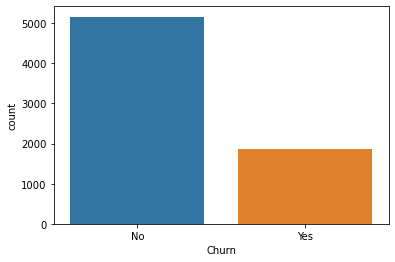

In [15]:
#Check the distribution of customers that churned and remained 
print(df['Churn'].value_counts())
print(sns.countplot(x='Churn', data=df))

In [16]:
#Closer look at the share of Yes vs. No
Remained = df[df.Churn == 'Yes'].shape[0]
Churned = df[df.Churn == 'No'].shape[0]

Total_customers = Remained + Churned
Remained_ratio = ( Remained / Total_customers) * 100
Churned_ratio = ( Churned / Total_customers) * 100
 
print("{:.2f}".format(Remained_ratio),'% of individuals remained as customer.')
print("{:.2f}".format(Churned_ratio),'% of individuals ended their relationship with the company.')
print('')
print('This means that we have a 73% chance of correctly guessing if that client left the company.')

26.58 % of individuals remained as customer.
73.42 % of individuals ended their relationship with the company.

This means that we have a 73% chance of correctly guessing if that client left the company.


<AxesSubplot:xlabel='InternetService', ylabel='count'>

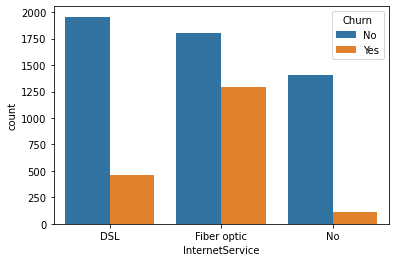

In [17]:
#Visualize distribution of churn count for certain classes
sns.countplot(x='InternetService', hue='Churn', data = df)

Tenure: Customers who have been with the company for long appear to remain a client
MonthlyCharges: In general, it seesm like clients who stayed pay a lower amount of monthly charges,
TotalCharges: However, it seems like TotalCharges follow a more similar pattern


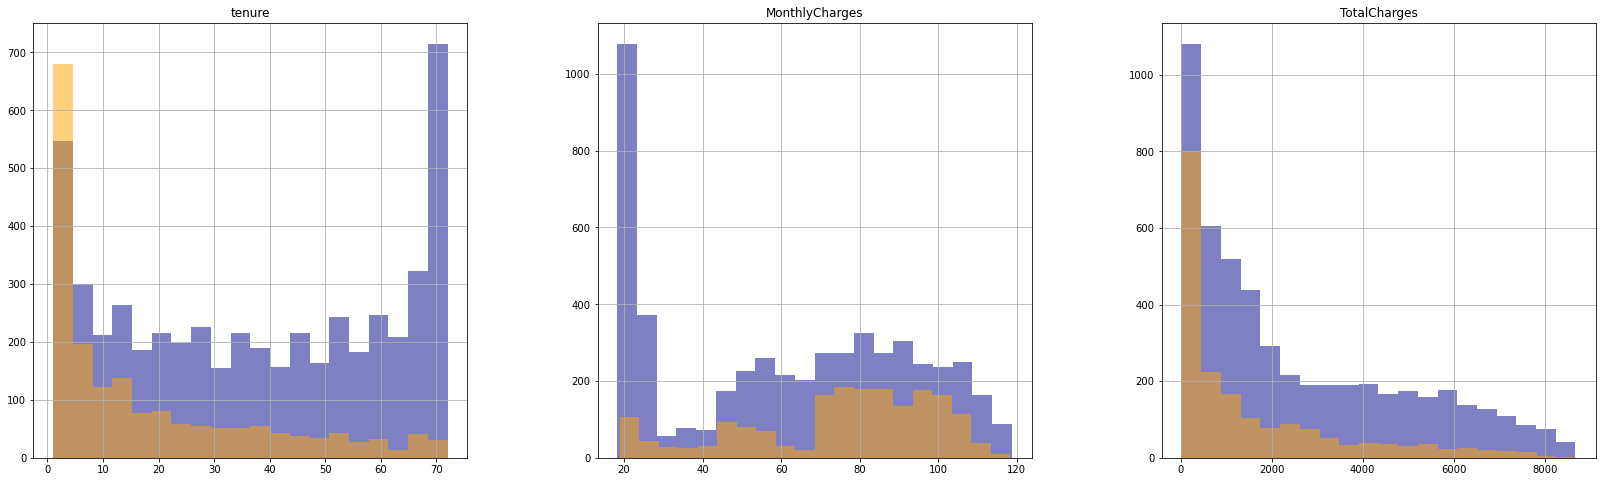

In [18]:
#Explore the numerical value distribution by churn variable
numerical_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
fig, ax = plt.subplots(1,3,figsize=(28,8))
df[df.Churn == 'No'][numerical_features].hist(bins=20, color='darkblue', alpha=0.5, ax = ax)
df[df.Churn == 'Yes'][numerical_features].hist(bins=20, color='orange', alpha=0.5, ax = ax)

print('Tenure: Customers who have been with the company for long appear to remain a client')
print('MonthlyCharges: In general, it seesm like clients who stayed pay a lower amount of monthly charges,')
print('TotalCharges: However, it seems like TotalCharges follow a more similar pattern')

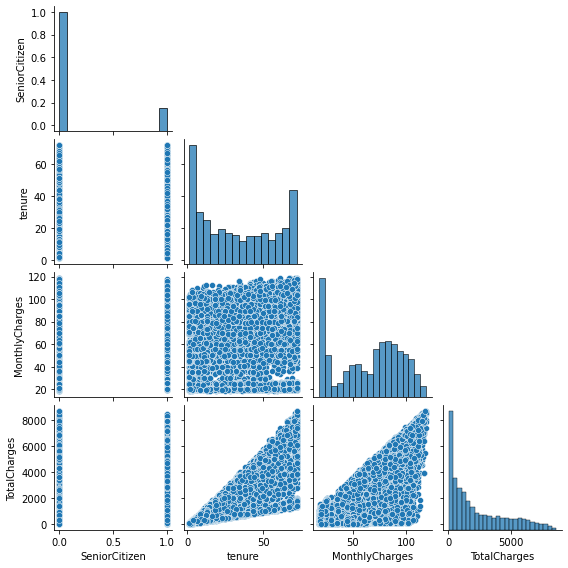

In [19]:
#Correlation Matrix
g = sns.pairplot(df, height=2)
for i, j in zip(*np.triu_indices_from(g.axes, 1)):
    g.axes[i, j].set_visible(False)

### Data Exploring Takeaways
1. We see that our classes are imbalanced, which means that we would be 

---

## Prepare Data for Machine Learning

In order to run the data through the machine learning models that we will be building, we need transform the dataset values from text to numerical. 

### Label Encode Target Variable

In [20]:
#Transform Yes/No to 1/0 to allow computation
le = preprocessing.LabelEncoder()
le.fit(df['Churn'])
df['Churn'] = le.transform(df['Churn'])
df.Churn

0       0
1       0
2       1
3       0
4       1
       ..
7038    0
7039    0
7040    0
7041    1
7042    0
Name: Churn, Length: 7032, dtype: int32

In [21]:
variable_values(df)

gender : ['Female' 'Male']
Partner : ['Yes' 'No']
Dependents : ['No' 'Yes']
PhoneService : ['No' 'Yes']
MultipleLines : ['No' 'Yes']
InternetService : ['DSL' 'Fiber optic' 'No']
OnlineSecurity : ['No' 'Yes']
OnlineBackup : ['Yes' 'No']
DeviceProtection : ['No' 'Yes']
TechSupport : ['No' 'Yes']
StreamingTV : ['No' 'Yes']
StreamingMovies : ['No' 'Yes']
Contract : ['Month-to-month' 'One year' 'Two year']
PaperlessBilling : ['Yes' 'No']
PaymentMethod : ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']


### Label Encode Binary Variables

In [22]:
#Looking at our unqiue values above, we see that there are a lot of binary variables
#These will also be label encoded
class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

In [23]:
#Encode all the binary variables
encoder = MultiColumnLabelEncoder(columns = ['gender','Partner', 'Dependents', 'PhoneService',
                                   'MultipleLines', 'OnlineSecurity','OnlineBackup',
                                   'DeviceProtection','TechSupport','StreamingTV',
                                   'StreamingMovies','PaperlessBilling'])

df = encoder.fit_transform(df)
df

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,1,0,0,DSL,0,1,0,0,0,0,Month-to-month,1,Electronic check,29.85,29.85,0
1,1,0,0,0,34,1,0,DSL,1,0,1,0,0,0,One year,0,Mailed check,56.95,1889.50,0
2,1,0,0,0,2,1,0,DSL,1,1,0,0,0,0,Month-to-month,1,Mailed check,53.85,108.15,1
3,1,0,0,0,45,0,0,DSL,1,0,1,1,0,0,One year,0,Bank transfer (automatic),42.30,1840.75,0
4,0,0,0,0,2,1,0,Fiber optic,0,0,0,0,0,0,Month-to-month,1,Electronic check,70.70,151.65,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,1,0,1,1,24,1,1,DSL,1,0,1,1,1,1,One year,1,Mailed check,84.80,1990.50,0
7039,0,0,1,1,72,1,1,Fiber optic,0,1,1,0,1,1,One year,1,Credit card (automatic),103.20,7362.90,0
7040,0,0,1,1,11,0,0,DSL,1,0,0,0,0,0,Month-to-month,1,Electronic check,29.60,346.45,0
7041,1,1,1,0,4,1,1,Fiber optic,0,0,0,0,0,0,Month-to-month,1,Mailed check,74.40,306.60,1


### OneHotEncode Multiclass Variables

In [24]:
#Transform the multiclass feature variables to dummies to allow computation
def to_dummy(data, column):
    #data = pd.get_dummies(data=df, columns=['InternetService'])
    return pd.get_dummies(data=data, columns=[column], drop_first=True) 

In [25]:
df = to_dummy(df, 'Contract')
df = to_dummy(df, 'InternetService')
df = to_dummy(df, 'PaymentMethod')

In [ ]:
df

In [27]:
df.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'PaperlessBilling', 'MonthlyCharges', 'TotalCharges', 'Churn',
       'Contract_One year', 'Contract_Two year', 'InternetService_Fiber optic',
       'InternetService_No', 'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check'],
      dtype='object')

---

### Rebalance Data By Resampling
We will downsample the majority class, i.e the class where the client churned. This will prevent biased accuracy when evaluating the machine learning models later on. However, with downsampling we miss out on a lot of information.

In [28]:
df.Churn.value_counts()

0    5163
1    1869
Name: Churn, dtype: int64

In [29]:
df_majority = df[df.Churn==0]
df_minority = df[df.Churn==1]

In [30]:
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=1869,     # to match minority class
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
#¤df_downsampled.value_counts()
# 1    49
# 0    49
# Name: balance, dtype: int64

In [31]:
df_downsampled.Churn.value_counts()

1    1869
0    1869
Name: Churn, dtype: int64

In [32]:
df_downsampled

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,MonthlyCharges,TotalCharges,Churn,Contract_One year,Contract_Two year,InternetService_Fiber optic,InternetService_No,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
5392,1,0,1,1,63,0,0,0,1,1,...,39.35,2395.05,0,0,1,0,0,0,0,0
4822,1,0,1,1,72,1,0,1,0,1,...,104.90,7559.55,0,0,1,1,0,1,0,0
2555,0,0,0,0,8,1,0,1,0,0,...,60.00,487.75,0,0,0,0,0,0,1,0
6013,0,1,1,0,50,1,1,0,0,0,...,100.65,5189.75,0,1,0,1,0,0,1,0
6263,0,0,0,0,25,0,0,0,0,1,...,54.20,1423.15,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7021,1,0,0,0,12,1,0,0,0,0,...,59.80,727.80,1,1,0,0,0,0,1,0
7026,0,0,0,0,9,1,0,0,0,0,...,44.20,403.35,1,0,0,0,0,0,0,0
7032,1,1,0,0,1,1,1,0,0,0,...,75.75,75.75,1,0,0,1,0,0,1,0
7034,0,0,0,0,67,1,1,1,1,1,...,102.95,6886.25,1,0,0,1,0,1,0,0


In [33]:
df_downsampled.Churn.value_counts()

1    1869
0    1869
Name: Churn, dtype: int64

### Split Data into Training and Test

In [222]:
# #Function for splitting data
# def split_data(data, test_size, random_state):
#     #drop the approval (classifiction) variable from data
#     feature_data = data.drop('Churn', 1)

#     #create independent variable data and target arrays
#     X = np.asarray(feature_data)
#     y = np.asarray(data['Churn'])

#     #split the data and check the shapes
#     return train_test_split(X, y, test_size = test_size, random_state=random_state)

In [224]:
#pass the dataframe to split_data function
#pass either df or df_downsampled
#X_train, X_test, y_train, y_test = split_data(df_downsampled, 0.20, 42)

#X_train, X_test, y_train, y_test = split_data(df, 0.20, 42)

In [288]:
#drop the approval (classifiction) variable from data
feature_data = df.drop('Churn', 1)

#create independent variable data and target arrays
#X = np.asarray(feature_data)
#y = np.asarray(df_downsampled['Churn'])

X = feature_data
y = df['Churn']

#split the data and check the shapes
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5625, 23), (1407, 23), (5625,), (1407,))

---

# STATISTICAL (TRADITIONAL) MACHINE MODELS 

### Introduction: Test Various Models

Here we're building a for loop to iterate over various models to see which one performs best in its default mode. Note that we're only looking at the basic accuracy measure here, which is no guarantee for a well-rounded robust model.

In [289]:
classifiers = [['DecisionTree :',DecisionTreeClassifier()],
               ['RandomForest :',RandomForestClassifier()], 
               ['Naive Bayes :', GaussianNB()],
               ['KNeighbours :', KNeighborsClassifier()],
               ['SVM :', SVC()],
               ['LogisticRegression :', LogisticRegression()],
               ['ExtraTreesClassifier :', ExtraTreesClassifier()],
               ['AdaBoostClassifier :', AdaBoostClassifier()],
               ['GradientBoostingClassifier: ', GradientBoostingClassifier()]]

predictions_df = pd.DataFrame()
predictions_df['actual_labels'] = y_test

In [290]:
for name,classifier in classifiers:
    classifier = classifier
    classifier.fit(X_train, y_train)
    predictions = classifier.predict(X_test)
    predictions_df[name.strip(" :")] = predictions
    print(name, accuracy_score(y_test, predictions))

DecisionTree : 0.7085998578535891
RandomForest : 0.7938877043354655
Naive Bayes : 0.7348969438521677
KNeighbours : 0.7704335465529495
SVM : 0.7341862117981521
LogisticRegression : 0.7867803837953091
ExtraTreesClassifier : 0.775408670931059
AdaBoostClassifier : 0.7938877043354655
GradientBoostingClassifier:  0.7896233120113717


#### Evaluate the Performance of Models in Default mode

In [291]:
#Function for evaluating a machine learning classifier
def evaluate_classifier(classifier):
    
    #Modeling
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    
    print("CLASSIFICATION REPORT:")
    print(" ")
    print(classification_report(y_test, y_pred))
    print(" ")
    #Confusion Matrix
    cm = tf.math.confusion_matrix(labels=y_test, predictions=y_pred)
    plt.figure(figsize = (6,4))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.xlabel('Predicted Values')
    plt.ylabel('True Values')
    print("CONFUSION MATRIX:")
    print(plt.show())
    print(" ")
    #Cross Validation
    scores = cross_val_score(classifier, X, y, cv=5)
    print("CROSS VALIDATION:")
    print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

CLASSIFICATION REPORT:
 
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1033
           1       0.64      0.48      0.54       374

    accuracy                           0.79      1407
   macro avg       0.73      0.69      0.70      1407
weighted avg       0.78      0.79      0.78      1407

 
CONFUSION MATRIX:


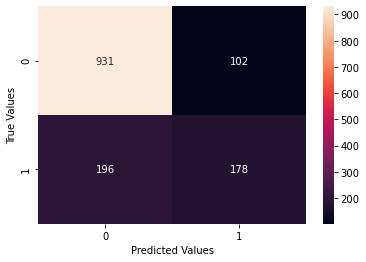

None
 
CROSS VALIDATION:
Accuracy: 0.79 (+/- 0.02)


In [292]:
#Evaluate classifier
evaluate_classifier(RandomForestClassifier())

#### Takeaway:
Two of the top performing classifiers were:

- Logistic Regression
- Random Forest

I will focus on these two when building more in-depths predictive models.

---

### DEFINE FUNCTIONS

#### Functions for visaulizing the model performance

In [293]:
#Building functions for visaulizing data
#Precision / Recall Curve
def pr_curve(model):
    plot_precision_recall_curve(model, X_test, y_test)
    return plt.show(), print("NOTE: Curve should lean top-right")

#ROC curve
def ROC_curve(model, name):

    #ROC Curve
    ns_probs = [0 for _ in range(len(y_test))]
    lr_probs = model.predict_proba(X_test)
    lr_probs = lr_probs[:, 1]

    # calculate scores
    ns_auc = roc_auc_score(y_test, ns_probs)
    lr_auc = roc_auc_score(y_test, lr_probs)
    # summarize scores
    print('No Skill: ROC AUC=%.3f' % (ns_auc))
    print(name,': ROC AUC=%.3f' % (lr_auc))
    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
    # plot the roc curve for the model
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(lr_fpr, lr_tpr, marker='.', label=name)
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # show the plot
    return plt.show(), print("NOTE: Curve should lean top-left")

#### Function for Model Evaluation

In [294]:
#Function for evaluating a machine learning model
def evaluate_model(model):
    #Predict rows
    y_pred = model.predict(X_test)
    
    print("CLASSIFICATION REPORT:")
    print(" ")
    print(classification_report(y_test, y_pred))
    print(" ")
    #Confusion Matrix
    cm = tf.math.confusion_matrix(labels=y_test, predictions=y_pred)
    plt.figure(figsize = (6,4))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.xlabel('Predicted Values')
    plt.ylabel('True Values')
    print("CONFUSION MATRIX:")
    print(plt.show())
    print(" ")
    #Cross Validation
    scores = cross_val_score(model, X, y, cv=5)
    print("CROSS VALIDATION:")
    print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

----------------

## MODEL 1 - Logistic Regression

The first model we're building is a logistic regression model

In [295]:
logistic = LogisticRegression()
scaler = StandardScaler()

#Build baseline model
pipe = Pipeline([('scaler', scaler), ('logistic', logistic)])

#Fit the model
pipe.fit(X_train, y_train)

#Test the model
pipe.score(X_test, y_test)

0.7874911158493249

### Hyperparameter Tuning
Find out which settings to use to achieve the most solid model

In [296]:
pipe.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()), ('logistic', LogisticRegression())],
 'verbose': False,
 'scaler': StandardScaler(),
 'logistic': LogisticRegression(),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'logistic__C': 1.0,
 'logistic__class_weight': None,
 'logistic__dual': False,
 'logistic__fit_intercept': True,
 'logistic__intercept_scaling': 1,
 'logistic__l1_ratio': None,
 'logistic__max_iter': 100,
 'logistic__multi_class': 'auto',
 'logistic__n_jobs': None,
 'logistic__penalty': 'l2',
 'logistic__random_state': None,
 'logistic__solver': 'lbfgs',
 'logistic__tol': 0.0001,
 'logistic__verbose': 0,
 'logistic__warm_start': False}

In [297]:
# Build the parameter grid
param_grid = {
    'logistic__C': np.logspace(-10, -4, 4, 10),
    'logistic__penalty':['l2','l1','elasticnet'],
    'logistic__class_weight':['balanced','none'],
    'logistic__solver':['lbfgs','newton-cg','liblinear','sag','saga'],
    'logistic__max_iter':[100, 1000, 5000]
}

In [298]:
#Search for the best hyperparameter setting
best_logreg = GridSearchCV(pipe, param_grid,
                           scoring='f1_micro',
                           n_jobs=-1)
best_logreg.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('logistic', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'logistic__C': array([1.e-10, 1.e-08, 1.e-06, 1.e-04]),
                         'logistic__class_weight': ['balanced', 'none'],
                         'logistic__max_iter': [100, 1000, 5000],
                         'logistic__penalty': ['l2', 'l1', 'elasticnet'],
                         'logistic__solver': ['lbfgs', 'newton-cg', 'liblinear',
                                              'sag', 'saga']},
             scoring='f1_micro')

In [299]:
#Analyze gridsearch model
print(best_logreg.best_params_)
print("Best parameter (CV score=%0.3f):" % best_logreg.best_score_)

{'logistic__C': 1e-06, 'logistic__class_weight': 'balanced', 'logistic__max_iter': 1000, 'logistic__penalty': 'l2', 'logistic__solver': 'sag'}
Best parameter (CV score=0.754):


In [300]:
#Build new pipeline using the best hyperparameter settings
logistic = LogisticRegression(class_weight='balanced',
                              max_iter=100, 
                              penalty='l2',
                              solver='sag')

#Build pipeline
pipe = Pipeline(steps=[('scaler', StandardScaler()), 
                        ('logistic', logistic)])

In [301]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('logistic',
                 LogisticRegression(class_weight='balanced', solver='sag'))])

In [302]:
pipe.score(X_test, y_test)

0.7313432835820896

### Visualize Logistic Regression Model

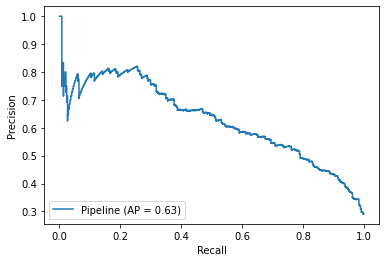

NOTE: Curve should lean top-right


(None, None)

In [303]:
#Precision / Recall Curve
pr_curve(pipe)

No Skill: ROC AUC=0.500
Logistic Regression : ROC AUC=0.832


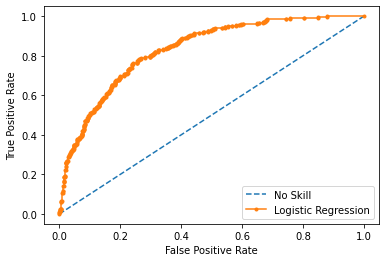

NOTE: Curve should lean top-left


(None, None)

In [304]:
#ROC Curve
ROC_curve(pipe, 'Logistic Regression')

### Evaluate Logistitc Regression Model

CLASSIFICATION REPORT:
 
              precision    recall  f1-score   support

           0       0.90      0.71      0.80      1033
           1       0.50      0.79      0.61       374

    accuracy                           0.73      1407
   macro avg       0.70      0.75      0.70      1407
weighted avg       0.80      0.73      0.75      1407

 
CONFUSION MATRIX:


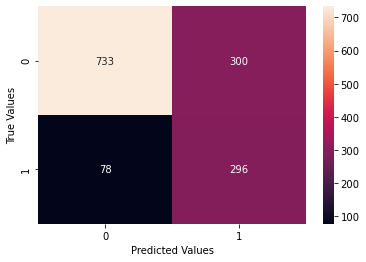

None
 
CROSS VALIDATION:
Accuracy: 0.75 (+/- 0.01)


In [305]:
evaluate_model(pipe)

### Logistic Regression Model Conslusion

#### Conclusing from using full training data
The logistic regression pipeline model has a solid class 0 precision, 90% of the predicted zeros were accurate. However, the overall performance is poor, particularly when it comes to the precision of customers how remained.

#### Conclusing from using downsampled training data
After having downsampled the majority class (0), we find that the logistic regression model looks more solid. All precision/recall scores are above 70%, which is good given that the classes are now balance 50% (i.e. if we guessed a class without the model, we would have 50% chance of being correct).

----------------

## MODEL 2 - Random Forest

In [306]:
#Define baseline model
rf = RandomForestClassifier()

#Find what hyperparameters are used by random forest
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [307]:
#Create hyperparameter grid
param_grid = {
    'n_estimators': [50, 250, 500],
    'max_features': ['sqrt', 0.25, 1.0],
    'min_samples_split': [2, 4, 6]
}

In [308]:
# Instantiate the grid search model
grid_search=GridSearchCV(estimator=rf, 
                         param_grid=param_grid,
                         cv=2, 
                         n_jobs=-1,
                         verbose=2)

### WARNING: Heavy computation in next cell

In [309]:
grid_search.fit(X_train, y_train)

Fitting 2 folds for each of 27 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:   56.3s finished


GridSearchCV(cv=2, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_features': ['sqrt', 0.25, 1.0],
                         'min_samples_split': [2, 4, 6],
                         'n_estimators': [50, 250, 500]},
             verbose=2)

In [310]:
#Get best hyperparameters
grid_search.best_params_

#Define best model
best_random = grid_search.best_estimator_

### Visualize Random Forest Model

No Skill: ROC AUC=0.500
Random Forest : ROC AUC=0.823


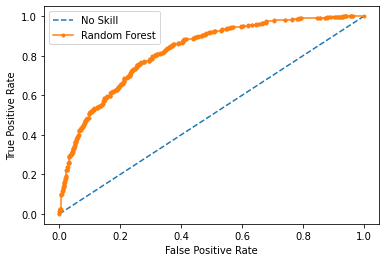

NOTE: Curve should lean top-left


(None, None)

In [311]:
ROC_curve(best_random, 'Random Forest')

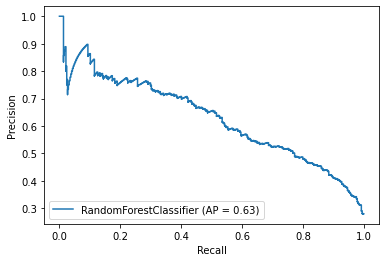

NOTE: Curve should lean top-right


(None, None)

In [312]:
pr_curve(best_random)

### Evaluate Random Forest Model

CLASSIFICATION REPORT:
 
              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1033
           1       0.66      0.48      0.56       374

    accuracy                           0.80      1407
   macro avg       0.74      0.69      0.71      1407
weighted avg       0.78      0.80      0.78      1407

 
CONFUSION MATRIX:


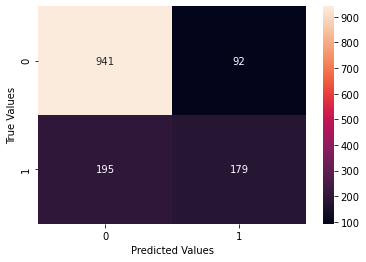

None
 
CROSS VALIDATION:
Accuracy: 0.80 (+/- 0.02)


In [313]:
evaluate_model(best_random)

### Random Forest Model Conslusion

#### Conclusing from using full training data
The random forest model's outcome is quite different from the logistic regression. This time, recall is higher than precision for class 0 (churned customers). However, this model is poor when predicting class 1.

Given that the two models performs well in disparate areas, we'll build an ensemble model to see if we can create a more robust model.

#### Conclusing from using downsampled training data
Again, when we use the downsampled data (where class 0 #data points = class 1 #data points), the model looke more solid. However, recall for class 0 is decrease from ~90% to >70%.


## FEATURE ENGINEERING: Random Forest Model

Before combining the random forest and logistic regression models into an ensemble model, we will build a random forest model based on the features that are most important when running the model.

### Feature Importance of Random Forest Model

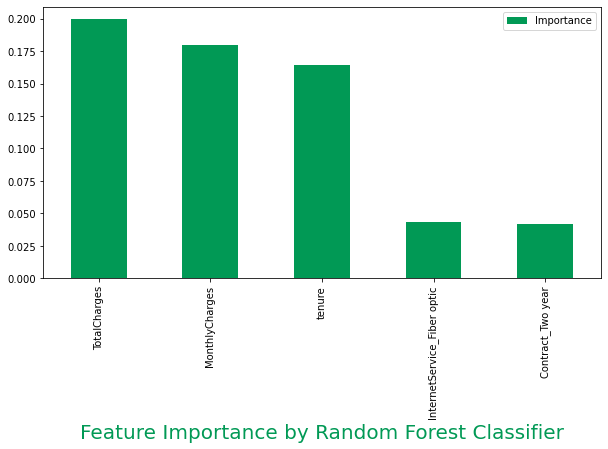

In [314]:
feature_importance_ = pd.DataFrame(
    {'Importance' : RandomForestClassifier().fit(X, y).feature_importances_}
    , index = X.columns)

feature_importance_.sort_values(by = 'Importance', ascending = False, axis = 0)[:5].plot(kind = 'bar', color = '#019955', figsize = (10, 5))
plt.xlabel("Feature Importance by Random Forest Classifier", color = "#019955", fontdict= {"fontsize" : 20});

In [315]:
#Create dataset with the above variables

X_train_new = X_train[['TotalCharges', 'tenure', 'MonthlyCharges', 'Contract_Two year', 'InternetService_Fiber optic']]
X_test_new = X_test[['TotalCharges', 'tenure', 'MonthlyCharges', 'Contract_Two year', 'InternetService_Fiber optic']]


In [316]:
grid_search.fit(X_train_new, y_train)

Fitting 2 folds for each of 27 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:   59.2s finished


GridSearchCV(cv=2, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_features': ['sqrt', 0.25, 1.0],
                         'min_samples_split': [2, 4, 6],
                         'n_estimators': [50, 250, 500]},
             verbose=2)

In [317]:
#Get best hyperparameters
grid_search.best_params_

#Define best model
best_random = grid_search.best_estimator_

              precision    recall  f1-score   support

           0       0.81      0.88      0.85      1033
           1       0.57      0.44      0.50       374

    accuracy                           0.76      1407
   macro avg       0.69      0.66      0.67      1407
weighted avg       0.75      0.76      0.75      1407



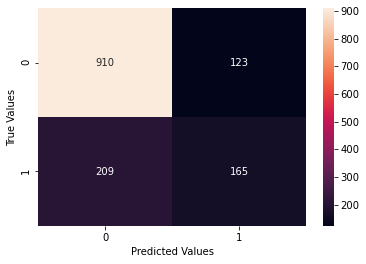

In [318]:
#Predict rows
y_pred = best_random.predict(X_test_new)

print(classification_report(y_test, y_pred))

#Confusion Matrix
cm = tf.math.confusion_matrix(labels=y_test, predictions=y_pred)

plt.figure(figsize = (6,4))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.show()

#### Feature Engineering Conclusion 
The model did not improve after extracting important features

----------------

## MODEL 3 - Ensemble Model

Combine the Logistic Regression and Random Forest models to create a more robust model.

In [319]:
#combine random forest and logistic regression
ensemble = VotingClassifier(estimators=[('rf', best_random), ('logreg', pipe)], voting='soft')

#fit the model
ensemble.fit(X_train, y_train)

#make predictions
predictions = ensemble.predict(X_test)
print(accuracy_score(y_test, predictions))

0.7654584221748401


### Visaulize Ensemble Model

No Skill: ROC AUC=0.500
Ensemble : ROC AUC=0.834


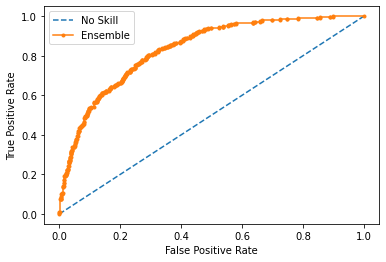

NOTE: Curve should lean top-left


(None, None)

In [320]:
#ROC Curve
ROC_curve(ensemble, 'Ensemble')

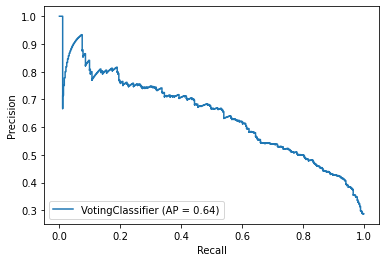

NOTE: Curve should lean top-right


(None, None)

In [321]:
#Precision / Recall
pr_curve(ensemble)

### Evaluate Ensemble Model

CLASSIFICATION REPORT:
 
              precision    recall  f1-score   support

           0       0.87      0.80      0.83      1033
           1       0.55      0.66      0.60       374

    accuracy                           0.77      1407
   macro avg       0.71      0.73      0.72      1407
weighted avg       0.78      0.77      0.77      1407

 
CONFUSION MATRIX:


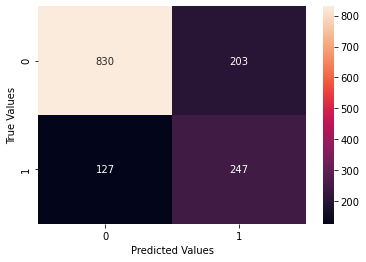

None
 
CROSS VALIDATION:
Accuracy: 0.78 (+/- 0.02)


In [323]:
evaluate_model(ensemble)

### Ensemble Model Conslusion

#### Conclusing from using full training data
The ensemble model, which is an average of the random forest and logistic regression, appears to be slightly more robust. 
- The model accurately predicts approximately 8 out of 10 (80%) of the clients that churned
- Out of the clients that the model predicted as lost, approximately 9 out of 10 (87%), were actually lost

#### Conclusing from using downsampled training data

---

# DEEP LEARNING MODEL

The second machine learning section of this notebook consists of a deep learning model.

In [71]:
dl_model = keras.Sequential([
    keras.layers.Dense(23, input_shape=(23,),activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(20, activation='relu'),
    keras.layers.Dense(10, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

In [72]:
dl_model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

model_history = dl_model.fit(x=X_train, 
                             y=y_train, 
                             epochs=10,
                             validation_split=0.2)

Train on 4500 samples, validate on 1125 samples
Epoch 1/10
4500/4500 [==============================] - 1s 254us/sample - loss: 10.6505 - accuracy: 0.6302 - val_loss: 0.9541 - val_accuracy: 0.6311
Epoch 2/10
4500/4500 [==============================] - 0s 83us/sample - loss: 2.3716 - accuracy: 0.6553 - val_loss: 0.5986 - val_accuracy: 0.7067
Epoch 3/10
4500/4500 [==============================] - 0s 83us/sample - loss: 1.2387 - accuracy: 0.6709 - val_loss: 0.6050 - val_accuracy: 0.6320
Epoch 4/10
4500/4500 [==============================] - 0s 86us/sample - loss: 1.1016 - accuracy: 0.7056 - val_loss: 0.6061 - val_accuracy: 0.7742
Epoch 5/10
4500/4500 [==============================] - 0s 86us/sample - loss: 0.9114 - accuracy: 0.7198 - val_loss: 0.5470 - val_accuracy: 0.7707
Epoch 6/10
4500/4500 [==============================] - 0s 84us/sample - loss: 0.7582 - accuracy: 0.7322 - val_loss: 0.5263 - val_accuracy: 0.7600
Epoch 7/10
4500/4500 [==============================] - 0s 85us/samp

### Visualzie Deep Learning Model Performance

Text(0, 0.5, 'accuracy')

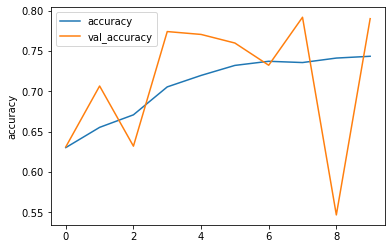

In [73]:
# Visualize accuracy history
df_result = pd.DataFrame(model_history.history)
df_result[['accuracy', 'val_accuracy']].plot()
plt.ylabel('accuracy')

Text(0, 0.5, 'loss')

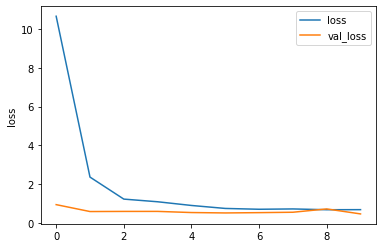

In [74]:
# Visualize loss history
df_result[['loss', 'val_loss']].plot()
plt.ylabel('loss')

### Deep Learning Evaluation & Prediction

In [75]:
#Evaluate the model on our test dataset
dl_model.evaluate(X_test, y_test)

1407/1407 [==============================] - 0s 28us/sample - loss: 0.4826 - accuracy: 0.7825


[0.482648324017501, 0.782516]

In [76]:
#Make predictions based on X_test data
y_pred = dl_model.predict(X_test)
y_pred[y_pred <= 0.5] = 0
y_pred[y_pred > 0.5] = 1

y_pred

array([[0.],
       [0.],
       [1.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)

In [77]:
#Run classfication report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.92      0.86      1033
           1       0.65      0.40      0.49       374

    accuracy                           0.78      1407
   macro avg       0.73      0.66      0.68      1407
weighted avg       0.77      0.78      0.76      1407



Text(33.0, 0.5, 'True Values')

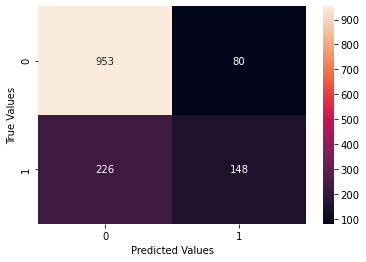

In [78]:
cm = tf.math.confusion_matrix(labels=y_test, predictions=y_pred)

plt.figure(figsize = (6,4))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted Values')
plt.ylabel('True Values')

### Deep Learning Model Conslusion

The deep learning model predicts way too many classes as churned clients.

## Model Comparison Conclusion

Unfortunately none of the models performed well accross the board. While the recall and precision scores were strong for one class, it was worse for the other.

However, considering the business case, it is more important to accurately identify those clients that are at risk of churning. It would probably be more costly to miss out on the opportunity to persuade a client to stay with a discount, than it would be to offer more than necessary discounts. 

# Saving Model

In [ ]:
model_dir = '../model'
model_name = 'clf_rf_{}'.format(now)
